# Минимизация сложности в смарт контрактах для выплат дивидендов

Инвесторы приобретают ценные бумаги, что дает им право получать часть прибыли от активов (дивиденды). Выплаты дивидендов могут быть реализованы в децентрализованных сетях посредством исполнения смарт контрактов. Данная работа нацелена на разработку алгоритмов эффективной выплаты дивидендов, минимизирующих количество потребляемого газа для различных автоматизированных сценариев. Реализация алгоритмов ведется на языке программирования смарт контрактов Solidity. В данной работе предложено несколько алгоритмов, а также показано преимущество каждого из них для различных сценариев.


## Постановка задачи


Целью работы является разработка и реализация алгоритмов, которые позволяли бы решать задачу выплаты дивидендов эффективно. Заранее известна матрица выплат, столбцы которой отвечают за ценные бумаги, строки за финансовые активы, а значения соответствующих ячеек за количество актива в ценной бумаге. После произвольной обработки заданной матрицы выплат, а также ее загружения в смарт контракт, необходимо уметь, принимая на вход массив стоимостей соответствующих активов, вычислять количество денег, которое положено каждому инвестору в соответствии с заранее известной матрицей выплат. 

Говоря более формальным языком, постановку задачи выплат дивидендов можно описать следующим образом:

* Есть матрица $A \in \mathbb{R}^{m \times n}$, где $m$ – количество различных финансовых активов, а $n$ – число ценных бумаг. Значение ячейки $A_{i, j}$ содержит в себе количество $i$-го актива в $j$-ой ценной бумаге.
    
* Имеется вектор-столбец $C \in \mathbb{R}^{m}$ стоимостей финансовых активов $C = (C_1, \ldots, C_m)^T$, где $C_{i}$ – стоимость $i$-го актива.
    
* Есть вектор $I \in \mathbb{R}^{n}$ соответствий ценных бумаг и инвесторов, т.е. $I_{i}$ – номер инвестора, вложившийся $i$-ую в ценную бумагу.

Требуется произвести выплату дивидендов. А именно, инвестор с номером $i$ должен получить на свой счет сумму денег, соответствующую всем ценным бумагам, которые он приобрел. Если обозначить через $\text{cost}[s]$ – "прибыль" $s$-ой ценной бумаги, а через $\text{balances}[i]$ – прибыль $i$-го инвестора, то:

$$
\text{balances}[i] = \sum \limits_{s = 1}^{n} \text{cost}[s] \cdot [i = I_s]
\text{, где }
[a = b] =
\begin{cases}
   1 &\text{если $a = b$}\\
   0 &\text{если $a \neq b$}
 \end{cases}
$$

\begin{equation}\label{equation-cost}
\text{cost}[s] = \sum \limits_{i = 1}^{m} C_{i} A_{i, s} \Longleftrightarrow{} \text{cost} = C^T A = (A^T C)^T
\end{equation}

Целью является вычисления массива $\text{balances}[i]$ алгоритмически по входным данным $A, C, I$ таким образом, чтобы количество потребляемого газа в смарт контракте было минимально возможным. 


## Тестируем реализации

На данный момент мною реализовано 4 алгоритма для payout-функции:

1. Наивная реализация: `payoutNaive`. Хранит матрицу в несжатом виде, алгоритм выплаты – наивный
2. Алгоритм для разреженной матрицы: `payoutSparse`. Хранит матрицу в сжатом виде (формат *COO*)
3. Алгоритм для дублирующихся столбцов: `payoutRepeatedColumns`. Хранит матрицу в сжатом виде
4. Алгоритм для малоранговой матрицы: `payoutLowRank`. Случай повторяющихся столбцов *(3)* является частным случаем малоранговой матрицы, но при этом в нем можно сделать более эффективную оптимизацию количества газа.

Посмотрим, какие преимущества дает каждый из алгоритмов. Для этого протестируем эти алгоритмы для различных наборах входных данных:
* Плотные матрицы
* Разреженные матрицы (степень разреженности задается параметров `capacity`)
* Матрицы с повторяющимися столбцами
* Малоранговые матрицы
* Квадратные матрицы
* Прямоугольные высокие матрицы и прямоугольные широкие матрицы

In [49]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.linalg
import scipy.sparse.linalg as spla
import time
%matplotlib inline

In [50]:
import importlib.util
import checker
import test.test_generator as generator

importlib.reload(checker)
importlib.reload(generator)

<module 'test.test_generator' from '/Users/maksimshuklin/hse/coursework/test/test_generator.py'>

In [51]:
default_list_of_methods = [
    "payoutNaive",
    "payoutSparse",
    "payoutRepeatedColumns",
    "payoutLowRank",
    "payoutRepeatedInvestors",
]

method_plot_mapping = {
    "payoutNaive" : "naive",
    "payoutSparse" : "sparse",
    "payoutRepeatedColumns" : "repeat-columns",
    "payoutLowRank" : "low-rank",
    "payoutRepeatedInvestors" : "investor-based",
}

Функция, которая позволяет для каждого из методов выплаты дивиденов подсчитывать количество газа, которое требуется данному методу в соответствии с
1. Спецификой матрицы – передается генератор матриц, а также ее размеры
2. Спецификой распределения инвесторов по ценным бумагам – передается метод генерации инвесторов

In [52]:
def get_gas_info(X, gen_matrix, gen_investors, list_of_methods=default_list_of_methods):
    gas_measure = dict([(method, []) for method in list_of_methods])
    for x in X:
        matrix = gen_matrix(x)
        investors = gen_investors(x)
        assets_cost = [i for i in range(x)]
        j = checker.get_timings(matrix, assets_cost, investors)
        for method in list_of_methods:
            gas_measure[method].append(j.get(method))
    return [gas_measure[method] for method in list_of_methods]

In [53]:
def plot_gas_info(plot_title, X, gen_matrix, gen_investors, list_of_methods=default_list_of_methods):
    for method, gas_list in zip(list_of_methods, get_gas_info(X, gen_matrix, gen_investors, list_of_methods)):
        plt.plot(X, gas_list)
    plt.legend(list(map(lambda x : method_plot_mapping[x], list_of_methods)))
    plt.xlabel("n")
    plt.ylabel("gas")
    plt.title(plot_title)
    plt.grid(True)
    plt.show()

### Плотные матрицы

**Плотная матрица** – это матрица, в которой мало нулевых элементов. Не будем предполагать, что у этой матрицы есть какая-то особенная структура (малый ранг, повторяющиемся столбцы/элементы и т.д.)

Посмотрим, сколько газа потребляет каждый из алгоритмов в данном случае:

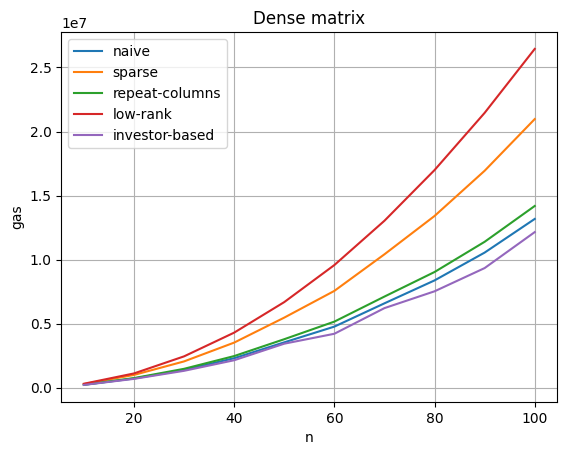

In [54]:
X_dense = [10 * i for i in range(1, 11)]
plot_gas_info(
    "Dense matrix",
    X_dense,
    lambda x : generator.generate_random(x, x),
    lambda x : generator.generate_investors_crp(x, 2)
)

**Вывод:**

Видно, что с плотными матрицами быстрее работает алгоритм `payoutNaive`, который рассчитывает размер диведендов и хранит матрицу в явном виде без каких-либо оптимизаций.

При этом, как можно видеть, алгоритм `payoutSparse`, предназначенных для разреженных матриц, работает заметно хуже других алгоритмов. Это можно легко объясняется следующим фактом: для разреженной матрицы с $k$ элементами требуется хранить 3 массива размера $k$, что в случае плотных занимает в $3$ раза больше пямяти, чем наивный подход.

### Разреженные матрицы

**Разреженная матрица** – это матрица, в которой много нулей (обычно больше, чем ненулевых элементов). Не будем предполагать в этом пункте, что у матрицы есть какая-либо дополнительная структура, кроме разреженности.

Посмотрим, каким образом будет вести себя количество потребляемого газа в зависимости от используемого алгоритма и степени разреженности матрицы (`capacity`):

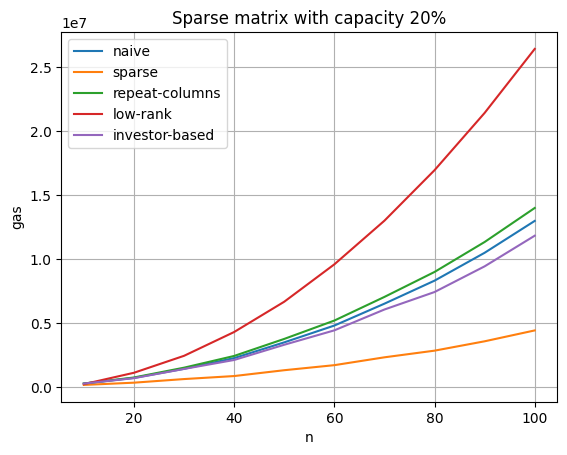

In [55]:
X_sparse = [10 * i for i in range(1, 11)]
plot_gas_info(
    "Sparse matrix with capacity 20%",
    X_sparse,
    lambda x : generator.generate_sparse(x, x),
    lambda x : generator.generate_investors_crp(x, 2)
)

**Вывод:**

Видно, что алгоритм для разреженных матриц заметно выигрывает (разница более чем в два раза).

При этом, что интересно подметить, алгоритм `payoutRepeatedColumns` для матриц с одинаковыми столбцами несколько медленне, чем наивный `payoutNaive`. Объяснить этом можно тем, что из-за особенности хранения данных в `payoutRepeatedColumns`, на матрицах без нужной структуры есть небольшой оверхед, по сравнению с `payoutNaive`

### Повторяющиеся столбцы

Под матрицей с повторяющимися столбцами будем подразумевать следующее:

* Пусть есть некоторый набор столбцов $A_1, \ldots, A_k$, где $k << n$
* Тогда искомая матрица $A \in \mathbb{R}^{n \times n}$ имеет вид:
$$
A = \left( A_{i_1} | A_{i_2} | \ldots | A_{i_n} \right) \text{, где } i_j = 1 \ldots k
$$

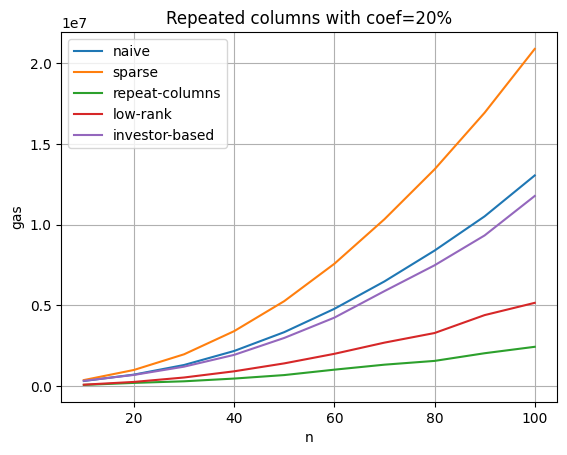

In [56]:
X_repeated = [10 * i for i in range(1, 11)]
plot_gas_info(
    f"Repeated columns with coef=20%",
    X_repeated,
    lambda x : generator.generate_repeated_columns_by_capacity(x, x, 20),
    lambda x : generator.generate_investors_crp(x, 2)
)

### Матрицы малого ранга

В данном разделе будем предполагать, что исходная матрица $A \in \mathbb{R}^{n \times n}$ имеет ранг, заметно меньший, чем $n$, т.е. $rank{A} \ll n$. Например, $k \approx \frac{1}{5}n$. 

Параметр ``capacity`` задает отношение $\frac{rank A}{n}$. Положим в данной секции, что ``capacity = 20%``

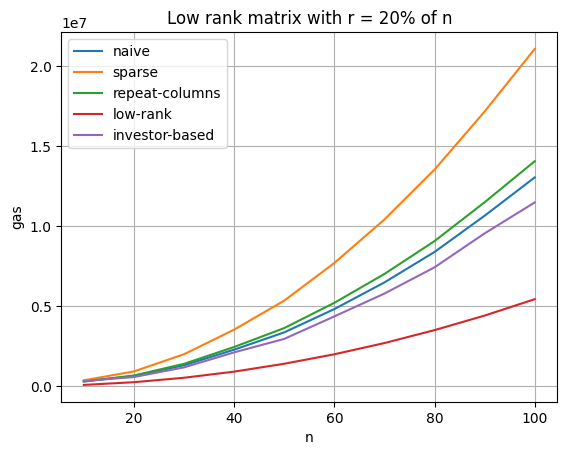

In [57]:
X_low_rank = [10 * i for i in range(1, 11)]
plot_gas_info(
    f"Low rank matrix with r = 20% of n",
    X_low_rank,
    lambda x : generator.generate_low_rank_by_capacity(x, x, 20),
    lambda x : generator.generate_investors_crp(x, 2)
)

### Example of different coefficients in Chinese Restaurant Process (case of dense square matrices):

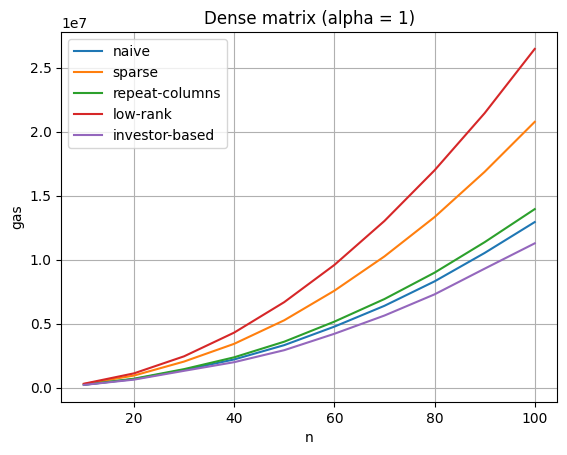

In [77]:
X_dense = [10 * i for i in range(1, 11)]
plot_gas_info(
    "Dense matrix (alpha = 1)",
    X_dense,
    lambda x : generator.generate_random(x, x),
    lambda x : generator.generate_investors_crp(x, 1)
)

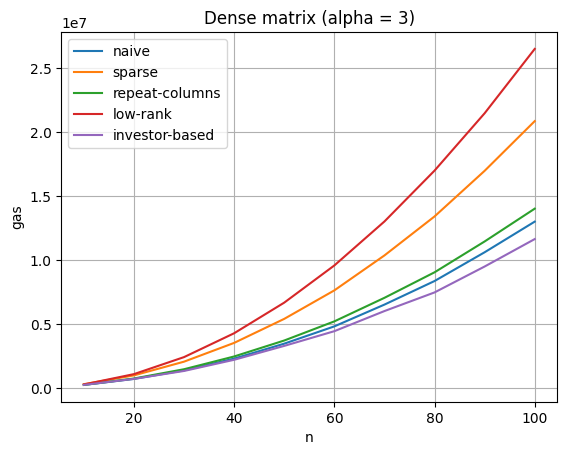

In [78]:
X_dense = [10 * i for i in range(1, 11)]
plot_gas_info(
    "Dense matrix (alpha = 3)",
    X_dense,
    lambda x : generator.generate_random(x, x),
    lambda x : generator.generate_investors_crp(x, 3)
)

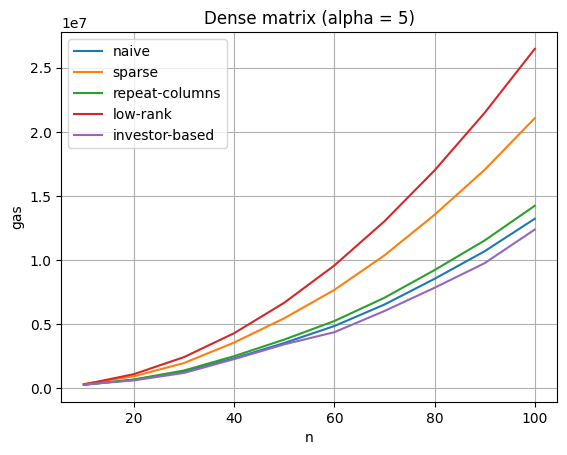

In [79]:
X_dense = [10 * i for i in range(1, 11)]
plot_gas_info(
    "Dense matrix (alpha = 5)",
    X_dense,
    lambda x : generator.generate_random(x, x),
    lambda x : generator.generate_investors_crp(x, 3)
)

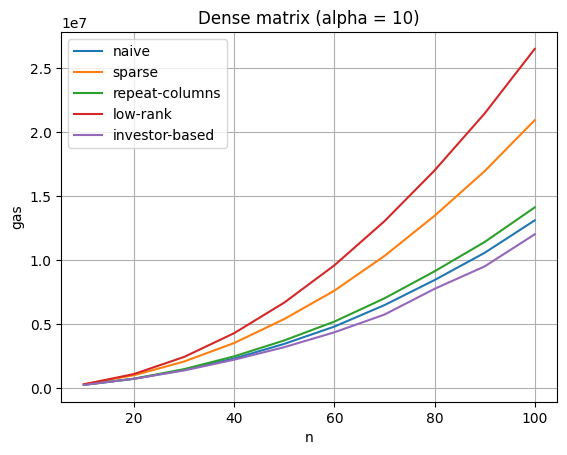

In [80]:
X_dense = [10 * i for i in range(1, 11)]
plot_gas_info(
    "Dense matrix (alpha = 10)",
    X_dense,
    lambda x : generator.generate_random(x, x),
    lambda x : generator.generate_investors_crp(x, 3)
)

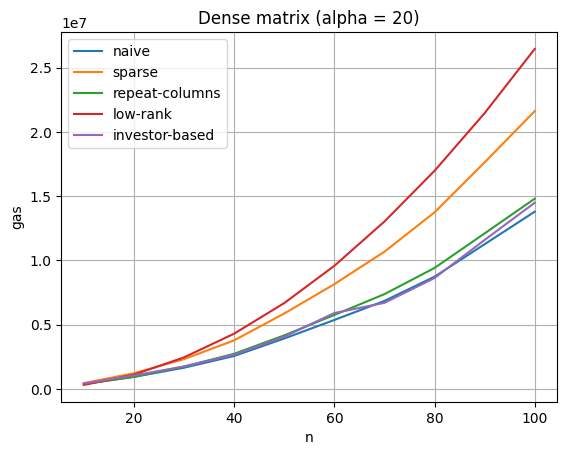

In [81]:
X_dense = [10 * i for i in range(1, 11)]
plot_gas_info(
    "Dense matrix (alpha = 20)",
    X_dense,
    lambda x : generator.generate_random(x, x),
    lambda x : generator.generate_investors_crp(x, 20)
)

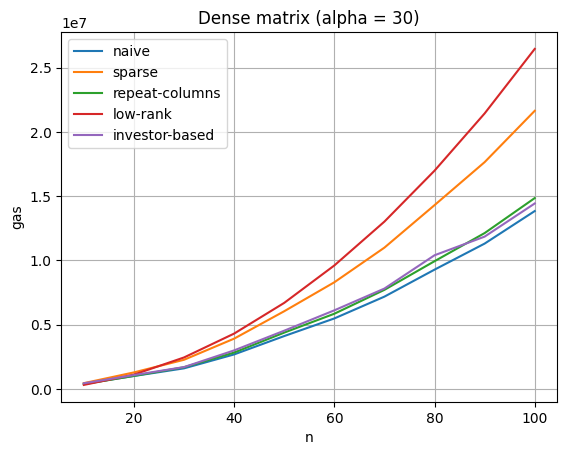

In [82]:
X_dense = [10 * i for i in range(1, 11)]
plot_gas_info(
    "Dense matrix (alpha = 30)",
    X_dense,
    lambda x : generator.generate_random(x, x),
    lambda x : generator.generate_investors_crp(x, 30)
)